The following cell defines the functions that are used to collect and filter data from the California Independent System Operator's (CAISO) online API "Open Access Same-time Information System" (OASIS). The functions download data from OASIS, select the relevant data for each input feature desired, and save the data as a CSV file in the user-specified 'folder_path'. 

The only function which the user need directly call is the 'create_datesets' function defined at the bottom of the cell. Before this, however, in addition to specifying a folder in which the data is to be cached, the user must also define a list, 'conditioning_df_creator_list', which contains the list of functions corresponding to the input features the user wishes to use in the model. An example of this is in the third code cell below, labeled "Set training hyperparameters and build model". 

In calling the 'create_datasets' function, one must specify four datetime values: 'start_datetime', 'train_cutoff', 'val_cutoff', and 'end_datetime'. The start and end datetime values determines the time range for which data will be collected from the API, and the data in the range from 'start_datetime' to 'train_cutoff' will be used for model training; from 'train_cutoff' to 'val_cutoff' for validation; and from 'val_cutoff' to 'end_datetime' for testing. 

In addition to specifying these datetimes, there are also many possible keyword arguments one may wish to pass to 'create_datasets':
- One has the option to specify the precise node in the CAISO network for which one wishes to collect data. The default is the trading hub node 'node = "TH_SP15_GEN-APND"'.
- One may also define a dictionary, 'thresholds', whose key values are the strings of the input feature names for which ones wishes to filter out outlier data points and whose corresponding values are pairs (min, max) that determine the range of non-outlier values
- We have also defined functions that collect data from the German EPEX SPOT market, and for this, one may pass 'region = "DE"' as a parameter. 

The outputs of each of the DataFrame creator functions is a DataFrame with datetime indices ranging from 'start_datetime' to 'end_datetime', inclusive, with 1h granularity. All DataFrames outputted have identical indices so that they may be combined into a single conditioning input DataFrame for use in training. 

We briefly describe the input feature functions here. Each description pertains to a single hour. We assume familiarity with electricity market jargon. 
- 'create_hasp_da_diff_df': a 4d vector containing the differences between the HASP LMP forecast (15 minute) and the day-ahead LMP forecast (hourly) for the previous hour. This is just the target data offshifted by 1 hour.
- 'create_lmp_da_delta_df': a 2d vector containing the forward and backward differences of the day-ahead LMP forecasts.
- 'create_renew_hasp_da_diff_df': a 2d vector containing the differences between HASP (hourly) and day-ahead forecasts for each of solar and wind generation. 
- 'create_temperature_df': a 2d vector containing the difference between the realized temperature and the average temperature recorded at a specifed station (default San Benardino airport "SBD"), and either the realized temperature or the max(realized temperature - 100, 0), if 'heat_wave_cutoff = True' is passes as a parameter. 
- 'create_trig_time_df': a 2d vector containing the sine and cosine of the time of day.

Package versions:
TensorFlow 2.15.0
Pandas 2.2.0

In [2]:
import os
import requests
import zipfile
from io import BytesIO
from datetime import datetime, timedelta, date
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


# Where the files will live
folder_path = "/your/folder/path"

# Dictionary to store missing timestamps from CAISO data
missing = {}

# Dictionary for time granularity of data
data_granularity = {
    "lmp_da": "1h", 
    "lmp_hasp": "15min",
    "lmp_rtpd": "15min",
    "renew_da": "1h",
    "renew_hasp": "1h"
}


def extract_data_to_dataframe(response):
    with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
        with zip_file.open(zip_file.namelist()[0]) as csv_file:
            df = pd.read_csv(csv_file)
    return df


def request_df_from_api(data_type, start_datetime, end_datetime, node="TH_SP15_GEN-APND", max_tries = 2):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    
    params = {
        'resultformat': '6',
        'startdatetime': start_datetime.strftime('%Y%m%dT%H:%M-0000'),
        'enddatetime': end_datetime.strftime('%Y%m%dT%H:%M-0000'),
        'node': node,
    }
    
    # Note: can select day_ahead data by hour via API, though cannot through OASIS website
    if data_type == "lmp_da": # Hourly day-ahead data
        params['queryname'] = 'PRC_LMP'
        params['version'] = '12'
        params['market_run_id'] = 'DAM'
    elif data_type == "lmp_rtpd": # 15-minute data, 45 minutes ahead
        params['queryname'] = 'PRC_RTPD_LMP'
        params['version'] = '3'
        params['market_run_id'] = 'RTPD'
    elif data_type == "lmp_hasp": # 15-minute data, hour-ahead
        params['queryname'] = 'PRC_HASP_LMP'
        params['version'] = '3'
        params['market_run_id'] = 'HASP'
    elif data_type == "lmp_hasp": # 15-minute data, 45 minutes ahead
        params['queryname'] = 'PRC_RTPD_LMP'
        params['version'] = '3'
        params['market_run_id'] = 'RTPD'
    elif data_type == "renew_da":
        params['queryname'] = 'SLD_REN_FCST'
        params['version'] = '1'
        params['market_run_id'] = 'DAM'
        del params['node']
    elif data_type == "renew_hasp":
        params['queryname'] = 'SLD_REN_FCST'
        params['version'] = '1'
        params['market_run_id'] = 'HASP'
        del params['node']
    elif data_type == "lmp_rtd": # 5-minute realized data
        params['queryname'] = 'PRC_INTVL_LMP'
        params['version'] = '3'
        params['market_run_id'] = 'RTM'
        # Add more in future if desired. 

    tries = 0
    while tries < max_tries:
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()  # Raise an HTTPError for bad responses (status codes >= 400)
            return extract_data_to_dataframe(response)
        except requests.exceptions.RequestException as e:
            print(f"An error occurred during the API request: {str(e)}")
            print(f"Waiting for 5 seconds before retrying... (Retry attempt {tries + 1}/{max_tries})")
            time.sleep(5)
            tries += 1
    print(f"Maximum number of tries ({max_tries}) reached. Go fix things.")
    return None


def generate_file_path(data_type, start_datetime, end_datetime, **kwargs):
    start_date_str = start_datetime.strftime("%Y%m%dT%H")
    end_date_str = end_datetime.strftime("%Y%m%dT%H")

    file_name = f"{data_type}_{start_date_str}_{end_date_str}_"
    for key, value in kwargs.items():
        file_name += f"{value}_"
    file_name = file_name[:-1]

    file_path = os.path.join(folder_path, file_name+".csv")
    return file_path


# Check if requested data already partially saved; return overlapping files and missing ranges
def find_overlapping_files(data_type, start_datetime, end_datetime, **kwargs):
    # Get suffix for file name, either node parameter, else is region parameter
    tail = kwargs.get("node", kwargs.get("region", None))
    # List of file names containing at least part of requested data
    overlapping_files = []
    covered_ranges = []

    for file_name in os.listdir(folder_path): # relevant CSVs should be contained in top directory
        if file_name.startswith(data_type) and file_name.endswith(tail+".csv"):
            datetime_strs = file_name[len(data_type)+1 : -len(tail)-5].split("_")
            df_start_datetime = pd.to_datetime(datetime_strs[0], format="%Y%m%dT%H", utc=True)
            df_end_datetime = pd.to_datetime(datetime_strs[1], format="%Y%m%dT%H", utc=True)
            
            # Check for overlap between file's date range and requested date range
            if ((start_datetime <= df_start_datetime < end_datetime) or 
                (start_datetime < df_end_datetime <= end_datetime) or
                (df_start_datetime <= start_datetime < df_end_datetime)):
                overlapping_files.append(file_name)
                covered_ranges.append((df_start_datetime, df_end_datetime))

    if not covered_ranges: 
        return overlapping_files, [(start_datetime, end_datetime)]
        
    # Sort covered ranges by start date
    covered_ranges.sort(key=lambda x: x[0])

    # Identify missing ranges within requested date range
    missing_ranges = []
    current_start = start_datetime

    for range in covered_ranges:
        if current_start < range[0]:
            missing_ranges.append((current_start, range[0]))
        current_start = max(current_start, range[1])

    if current_start < end_datetime:
        missing_ranges.append((current_start, end_datetime))
    
    return overlapping_files, missing_ranges


# Builds df and saves CSV file
def build_df(data_type, start_datetime, end_datetime, **kwargs):
    # Default region is 'CA'
    region = kwargs.get("region", "CA")
    
    # Dictionary for specifying how to fetch data dependent on region
    fetch_fn = {"CA":fetch_filtered_CA_data,
                "DE":fetch_filtered_DE_data
               }
    
    overlapping_files, missing_ranges = find_overlapping_files(data_type, start_datetime, end_datetime, **kwargs)

    if overlapping_files:
        dfs = []
        for file_name in overlapping_files:
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, parse_dates=["INTERVALSTARTTIME_GMT"], index_col="INTERVALSTARTTIME_GMT")
            dfs.append(df)

        partial_df = pd.concat(dfs)
    else:
        partial_df = pd.DataFrame(columns={"MW":None, "INTERVALSTARTTIME_GMT":None}).set_index("INTERVALSTARTTIME_GMT")

    if missing_ranges:
        print(f"Missed something, will fetch {data_type} data from API:", missing_ranges)
        fetched_dfs = [partial_df]
        for start, end in missing_ranges:
            fetched_df = fetch_fn[region](data_type, start, end, **kwargs)
            fetched_dfs.append(fetched_df)
        full_df = pd.concat(fetched_dfs)
    else:
        full_df = partial_df

    # Drop duplicate data
    full_df = full_df.reset_index().drop_duplicates().set_index("INTERVALSTARTTIME_GMT").sort_index()
    
    # Select relevant data to return
    full_df = full_df[start_datetime:end_datetime]
    
    # If collected any new data, save as CSV
    if missing_ranges:
        file_path = generate_file_path(data_type, start_datetime, end_datetime, **kwargs)
        full_df.to_csv(file_path)

    return full_df


# Extract and sort LMP values from LMP DataFrames for DA, RTPD, or RTD market
def filter_lmp_data(lmp_df):
    filtered_df = lmp_df[lmp_df["XML_DATA_ITEM"] == "LMP_PRC"].copy()
    filtered_df["INTERVALSTARTTIME_GMT"] = pd.to_datetime(filtered_df["INTERVALSTARTTIME_GMT"])
    filtered_df = filtered_df.set_index("INTERVALSTARTTIME_GMT").sort_index()
    
    # DA and HASP data use "MW", RTPD uses "PRC", RTD uses "VALUE"; blame CAISO for inconsistency
    if "MW" in filtered_df.columns:
        return filtered_df[["MW"]]
    elif "PRC" in filtered_df.columns:
        return filtered_df[["PRC"]]
    elif "VALUE" in filtered_df.columns:
        return filtered_df[["VALUE"]]
    else:
        print("DataFrame contains no column named 'MW', 'PRC', or 'VALUE'.")
        return filtered_df


# Extract and sort wind and solar MW data (for CA region)
# Note: API cannot separate (trading hub) nodes or renewable types
def filter_renew_data(renew_df):
    filtered_df = renew_df[["INTERVALSTARTTIME_GMT","TRADING_HUB","RENEWABLE_TYPE","MW"]].copy()
    filtered_df["INTERVALSTARTTIME_GMT"] = pd.to_datetime(filtered_df["INTERVALSTARTTIME_GMT"])
    filtered_df = filtered_df.set_index("INTERVALSTARTTIME_GMT").sort_index()

    return filtered_df


# Chunk the date range for API requests for CAISO OASIS
def get_date_chunks(start_date, end_date):
    current_date = start_date
    while current_date < end_date:
        yield current_date, min(current_date + timedelta(days=30), end_date)
        current_date += timedelta(days=30)


# Provide DataFrame filtered according to filter_{x}_data() functions for CA region
def fetch_filtered_CA_data(data_type, start_datetime, end_datetime, node="TH_SP15_GEN-APND"):
    # Assign data types to filter functions
    filter_function = {
        "lmp_da": filter_lmp_data, 
        "lmp_hasp": filter_lmp_data,
        "lmp_rtpd": filter_lmp_data,
        "renew_da": filter_renew_data,
        "renew_hasp": filter_renew_data
    }
    
    # Chunk date range for API requests
    date_chunks = get_date_chunks(start_datetime, end_datetime)

    # Create list to hold DFs produced by filter functions
    df_list = []

    # Iterate over date range in chunks
    for chunk_start, chunk_end in date_chunks:
        unfiltered_df = request_df_from_api(data_type, chunk_start, chunk_end, node=node)
        df_list.append(filter_function[data_type](unfiltered_df))

    full_df = pd.concat(df_list)
    
    return full_df


# Provide DataFrame for German market
def fetch_filtered_DE_data(data_type, start_datetime, end_datetime, **kwargs):
    start_year = start_datetime.year
    end_year = end_datetime.year
    
    # Collect data in lists
    time_data = []
    id3_data = []
    da_data = []

    current_year = start_year

    # Loop over given time range, one year at a time
    while(current_year <= end_year):
        url = f"https://energy-charts.info/charts/price_spot_market/data/de/year_15min_{current_year}.json"
        
        # Fetch data
        response = requests.get(url)
        data = response.json()
        
        try:
            time_data.extend(data[0]["xAxisValues"]) # Timestamps always in first dictionary it seems.
        except KeyError:
            print("Timestamps are elsewhere.")
            raise

        # Find ID3 data
        for dict in data:
            if isinstance(dict["name"],list) and dict["name"][0]["en"] == "Intraday Continuous 15 minutes ID3-Price":
                id3_data.extend(dict["data"])
                print("Found data for year", current_year)
                break # Finish the for-loop search for relevant data
            else:
                continue
                
        # Find day ahead data
        for dict in data:
            if isinstance(dict["name"],list) and dict["name"][0]["en"] == "Day Ahead Auction":
                da_data.extend(dict["data"])
                break # Finish the for-loop search for relevant data
            else:
                continue
        
        current_year += 1
            
    # Create DataFrame from data
    # Note: columns are called 'MW' for consistency, though it's (very) inaccurate
    if data_type == "id3":
        id3_df = pd.DataFrame(data={"MW": id3_data}, index=pd.to_datetime(time_data, unit="ms", utc=True))
        id3_df.rename_axis("INTERVALSTARTTIME_GMT", inplace=True)
        return id3_df
    elif data_type == "da":
        da_df = pd.DataFrame(data={"MW": da_data}, index=pd.to_datetime(time_data, unit="ms", utc=True))
        da_df.rename_axis("INTERVALSTARTTIME_GMT", inplace=True)
        return da_df
    else:
        print("Invalid data_type passed:", data_type)
        return


# Identify missing data and impute via linear interpolation
def impute_df(df, data_type):
    granularity = data_granularity[data_type]
    
    missing = pd.date_range(df.index.min(), df.index.max(), freq=granularity).difference(df.index)
    
    # Fill in missing timestamps
    filled_df = df.resample(granularity).asfreq() if len(missing)>0 else df
    
    # Interpolate numerical values
    filled_df.iloc[:,0] = filled_df.iloc[:,0].interpolate(method='linear')
    return filled_df, missing


# Input features: forward and backward differences of day-ahead LMP
def create_lmp_da_delta_df(start_datetime, end_datetime, node="TH_SP15_GEN-APND", **kwargs):
    # Fetch data from folder_path or API
    lmp_da_df = build_df("lmp_da", start_datetime-timedelta(hours=1), end_datetime+timedelta(hours=1), node=node)
    
    # Impute (linearly interpolate) any missing data
    lmp_da_df, _ = impute_df(lmp_da_df, "lmp_da")

    # Get hourly day-ahead differences for given range
    forward_difference = -lmp_da_df.diff(periods = -1).loc[start_datetime:end_datetime-timedelta(minutes=1)]
    backward_difference = lmp_da_df.diff().loc[start_datetime:end_datetime-timedelta(minutes=1)]
    
    forward_difference.rename(columns={"MW":"DA_Forward_Difference"}, inplace=True)
    backward_difference.rename(columns={"MW":"DA_Backward_Difference"}, inplace=True)

    # Merge along index and rename indices
    lmp_da_delta_df = pd.concat([forward_difference, backward_difference], axis=1)

    return lmp_da_delta_df

    
# Input features: (lmp_hasp_{x} - lmp_da) of previous hour for x in {0, 15, 30, 45}
def create_hasp_da_diff_df(start_datetime, end_datetime, node="TH_SP15_GEN-APND", **kwargs):
    # Fetch data from folder_path or API
    lmp_hasp_df = build_df("lmp_hasp", start_datetime - timedelta(hours=1), end_datetime, node=node)
    
    # Impute missing values
    lmp_hasp_df, missing_lmp_hasp = impute_df(lmp_hasp_df, "lmp_hasp")
    missing["lmp_hasp"] = missing_lmp_hasp

    # Fetch data from folder_path or API
    full_lmp_da_df = build_df("lmp_da", start_datetime-timedelta(hours=1), end_datetime+timedelta(hours=1), node=node)

    # Impute missing values
    full_lmp_da_df, _ = impute_df(full_lmp_da_df, "lmp_da")

    # Set new start/end datetimes to calculuate LMP difference of previous hour
    new_start_datetime = start_datetime-timedelta(hours=1)
    new_end_datetime = end_datetime-timedelta(hours=1, minutes=1) # Subtract 1 minute to handle edge case
    
    # Make DataFrame to hold (lmp_hasp_{x} - lmp_da) input features
    hasp_da_diff_df = pd.DataFrame(index = full_lmp_da_df[new_start_datetime:new_end_datetime].index)
    
    for i in range(4):
        # Form lmp_hasp_H{t-1}_M{x} - lmp_da_H{t-1} for x in {0, 15, 30, 45}
        hasp_da_diff_df[f"HASP_DA_diff_{i*15}"] = (
            lmp_hasp_df[new_start_datetime + timedelta(minutes=i*15):new_end_datetime:4].values - 
            full_lmp_da_df[new_start_datetime:new_end_datetime].values
        )

    # Shift indices ahead 1 hour to match with indices of other features
    hasp_da_diff_df.index = hasp_da_diff_df.index + pd.DateOffset(hours=1)

    return hasp_da_diff_df

# Input features: (solar_da - solar_hasp), (wind_da - wind_hasp) for current trading hour
# Note: HASP forecasts available before bid submission deadline
def create_renew_hasp_da_diff_df(start_datetime, end_datetime, node="TH_SP15_GEN-APND", **kwargs):
    # Fetch data from folder_path or API
    renew_da_df = build_df("renew_da", start_datetime, end_datetime, node="all_nodes").reset_index()
    renew_hasp_df = build_df("renew_hasp", start_datetime, end_datetime, node="all_nodes").reset_index()

    # Further filter for node, renewable types, and market
    renew_da_df = renew_da_df[renew_da_df["TRADING_HUB"] == node[3:7]]
    renew_hasp_df = renew_hasp_df[renew_hasp_df["TRADING_HUB"] == node[3:7]]
    
    wind_da_df = renew_da_df.loc[renew_da_df["RENEWABLE_TYPE"] == "Wind", ["INTERVALSTARTTIME_GMT","MW"]]
    wind_da_df.set_index("INTERVALSTARTTIME_GMT", inplace=True)
    solar_da_df = renew_da_df.loc[(renew_da_df["RENEWABLE_TYPE"] == "Solar"), ["INTERVALSTARTTIME_GMT","MW"]]
    solar_da_df.set_index("INTERVALSTARTTIME_GMT", inplace=True)
    wind_hasp_df = renew_hasp_df.loc[(renew_hasp_df["RENEWABLE_TYPE"] == "Wind"), ["INTERVALSTARTTIME_GMT","MW"]]
    wind_hasp_df.set_index("INTERVALSTARTTIME_GMT", inplace=True)
    solar_hasp_df = renew_hasp_df.loc[(renew_hasp_df["RENEWABLE_TYPE"] == "Solar"), ["INTERVALSTARTTIME_GMT","MW"]]
    solar_hasp_df.set_index("INTERVALSTARTTIME_GMT", inplace=True)
    
    # Impute missing values
    wind_da_df, missing_wind_da = impute_df(wind_da_df, "renew_da")
    solar_da_df, missing_solar_da = impute_df(solar_da_df, "renew_da")
    wind_hasp_df, missing_wind_hasp = impute_df(wind_hasp_df, "renew_hasp")
    solar_hasp_df, missing_solar_hasp = impute_df(solar_hasp_df, "renew_hasp")
    missing["wind_da"] = missing_wind_da
    missing["solar_da"] = missing_solar_da
    missing["wind_hasp"] = missing_wind_hasp
    missing["solar_hasp"] = missing_solar_hasp

    # Make DataFrames to hold forecast error input features
    wind_diff_df = pd.DataFrame(index = wind_da_df.index)
    wind_diff_df["Wind_Forecast_diff"] = (wind_hasp_df.values - wind_da_df.values)

    solar_diff_df = pd.DataFrame(index = solar_da_df.index)
    solar_diff_df["Solar_Forecast_diff"] = (solar_hasp_df.values - solar_da_df.values)

    renew_hasp_da_diff_df = pd.concat([wind_diff_df, solar_diff_df], axis=1)

    return renew_hasp_da_diff_df


# Input feature: (lmp_rtpd - lmp_da) DF for first 15 minutes of prev trading hour
# Note: full lmp_rtpd data for previous hour not available by bid submission deadline
def create_lmp_rtpd_da_diff_df(start_datetime, end_datetime, node="TH_SP15_GEN-APND", **kwargs):
    # Fetch data from folder_path or API
    lmp_rtpd_df =  build_df("lmp_rtpd", start_datetime-timedelta(hours=1), end_datetime, node=node)

    # Impute missing values
    lmp_rtpd_df, missing_lmp_rtpd = impute_df(lmp_rtpd_df, "lmp_rtpd")
    missing["lmp_rtpd"] = missing_lmp_rtpd
    
    # Fetch data from folder_path or API
    full_lmp_da_df = build_df("lmp_da", start_datetime-timedelta(hours=1), end_datetime+timedelta(hours=1), node=node)

    # Impute missing values
    full_lmp_da_df, _ = impute_df(full_lmp_da_df, "lmp_da")
    
    # Set new start/end datetimes to calculuate LMP difference of previous hour
    new_start_datetime = start_datetime-timedelta(hours=1)
    new_end_datetime = end_datetime-timedelta(hours=1, minutes=1) # Subtract 1 minute to handle edge case

    # Make DataFrame to hold input feature(rtpd_lmp_0 - da_lmp) of previous trading hour
    lmp_rtpd_da_diff_df = pd.DataFrame(index = full_lmp_da_df[new_start_datetime:new_end_datetime].index)
    
    lmp_rtpd_da_diff_df["RTPD_DA_diff_0"] = (
        lmp_rtpd_df[new_start_datetime:new_end_datetime:4].values - 
        full_lmp_da_df[new_start_datetime:new_end_datetime].values
    )

    # Shift indices ahead 1 hour to match with indices of other features
    lmp_rtpd_da_diff_df.index = lmp_rtpd_da_diff_df.index + pd.DateOffset(hours=1)

    return lmp_rtpd_da_diff_df


# Input feature: realized temperature if above 100 and average temperature data from ASOS for specified station
def create_temperature_df(start_datetime, end_datetime, data="tmpf", tz="Etc/UTC", **kwargs):
    # Note: We store the interpolated data, not the raw data from API request
    
    # Time range in which we request data to average; might not go all the way back
    wayback = datetime(1970, 1, 1, 8, 0, tzinfo=pytz.utc)
    today = datetime(2024, 2, 7, 8, 0, tzinfo=pytz.utc)

    station = kwargs.get("station", "SBD")
    
    overlapping_files, _ = find_overlapping_files("temperature", wayback, today, node=station)

    if overlapping_files:
        path = os.path.join(folder_path, overlapping_files[0])
        full_df = pd.read_csv(path, parse_dates=True, index_col="INTERVALSTARTTIME_GMT")
    else: 
        # Retrieve data from API
        # Construct URL with provided parameters
        base_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py"
        params = {
            "station": station,
            "data": data,
            "year1": wayback.year,
            "month1": wayback.month,
            "day1": wayback.day,
            "year2": today.year,
            "month2": today.month,
            "day2": today.day,
            "tz": tz,
            "missing": "null", 
            "format": "onlycomma",
            "direct": "yes", 
            "report_type": "3",
            **kwargs
        }
        
        # Send request to API
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            raw_full_df = pd.read_csv(BytesIO(response.content))
        else:
            print("Error: Failed to retrieve data!")
            print(f"Received message: {response.text}")

        # Skip first few null values if any and drop "station" column
        first_index = raw_full_df["tmpf"].first_valid_index()
        full_df = raw_full_df[first_index:][["valid", "tmpf"]]

        # Check that at least 99% of remaining 'tmpf' values are not null
        null_percent = full_df["tmpf"].isnull().sum() / len(full_df)
        if null_percent > 0.01:
            raise ValueError("More than 1% of 'tmpf' values are null")
    
        # Parse the "valid" column as tz-aware datetime objects
        full_df["valid"] = pd.to_datetime(full_df["valid"], utc=True)
        
        # Make datetime range that we care about
        desired_range = pd.date_range(start=start_datetime, end=end_datetime, freq="1h")
        augmentation = pd.DataFrame(columns=["valid"], data=desired_range)

        # Add in missing timestamps that we care about
        full_df = pd.concat([full_df, augmentation]).reset_index(drop=True).drop_duplicates(subset="valid")

        # Interpolate the values for the hourly timestamps and drop all others
        full_df = full_df.set_index("valid").sort_index().interpolate(method="time").resample("1h").asfreq()

        # Form a new column holding the difference from average "tmpf" for each hour of the year
        index = full_df.index
        full_df["tmpf_avg_tmpf_diff"] = full_df["tmpf"]-full_df.groupby([index.month, index.day, index.hour])["tmpf"].transform("mean")

        # Rename index to match with other feature/target DFs
        full_df.rename_axis("INTERVALSTARTTIME_GMT", inplace=True)

        # Save realized and averaged interpolated data
        file_path = generate_file_path("temperature", wayback, today, station)
        full_df.to_csv(file_path)

    # Select the sub-DF for the given datetime range
    temp_df = full_df[start_datetime:end_datetime-timedelta(minutes=1)]
    
    # Optional: consider degrees above 100 in place of actual temperature
    heat_wave_cutoff = kwargs.get("heat_wave_cutoff", False)
    if heat_wave_cutoff:
        temp_df["tmpf"] = temp_df["tmpf"].copy().apply(lambda x: max(x - 100, 0))

    return temp_df


# Target variable: (lmp_hasp_{x} - lmp_da) for current trading hour for x in {0, 15, 30, 45}
def create_target_df(start_datetime, end_datetime, **kwargs):
    region = kwargs.get("region", "CA")
    if region == "CA":
        intraday_type = "lmp_hasp"
        day_type = "lmp_da"
    elif region == "DE":
        intraday_type = "id3"
        day_type = "DA"
    
    # Fetch data from folder or API
    full_intraday_df = build_df(intraday_type, start_datetime-timedelta(hours=1), end_datetime, **kwargs)
    intraday_df = full_intraday_df.loc[start_datetime:]
        
    # Impute missing values
    intraday_df, _ = impute_df(intraday_df, "lmp_hasp")
    
    # Fetch data from folder_path or API
    full_da_df = build_df(day_type, start_datetime-timedelta(hours=1), end_datetime+timedelta(hours=1), **kwargs)

    # Impute missing values
    full_da_df, _ = impute_df(full_da_df, "lmp_da")

    # Subtract 1 minute to handle edge case 
    new_end_datetime = end_datetime-timedelta(minutes=1) 
    
    # Make DataFrame to hold (lmp_hasp_{x} - lmp_da) target variable DF
    target_df = pd.DataFrame(index = full_da_df[start_datetime:new_end_datetime].index)
    
    for i in range(4):
        # Form lmp_hasp_H{t}_M{x} - lmp_da_H{t} for x in {0, 15, 30, 45}
        target_df[f"target_{intraday_type}_DA_diff_{i*15}"] = (
            intraday_df[start_datetime + timedelta(minutes=i*15):new_end_datetime:4].values - 
            full_da_df[start_datetime:new_end_datetime].values
        )
    
    return target_df


# Create sine and cosine DataFrames
def create_trig_time_df(start_datetime, end_datetime, node="TH_SP15_GEN-APND", **kwargs):
    # Create series of time-zone aware datetime objects for [start_datetime, end_datetime)
    datetime_range = pd.date_range(
        start_datetime, 
        end_datetime - timedelta(minutes=1), 
        freq="1h", 
        name="INTERVALSTARTTIME_GMT"
    )

    sin_time = np.sin(2 * np.pi * datetime_range.hour / 24)
    cos_time = np.cos(2 * np.pi * datetime_range.hour / 24)
    
    # Create DataFrame with encoded time features
    time_features_df = pd.DataFrame({
        'sin_time': sin_time,
        'cos_time': cos_time
    }, index=datetime_range)

    return time_features_df


# Dict to hold values of input feature dimensionality
conditioning_dim_dict = {create_renew_hasp_da_diff_df: 2, 
                         create_lmp_da_delta_df: 2, 
                         create_lmp_rtpd_da_diff_df: 1, 
                         create_trig_time_df: 2, 
                         create_hasp_da_diff_df: 4,
                         create_temperature_df: 2
                        }


# Function for finding outlier indices given dictionary of threshold (max,min) values
def find_outliers(df, thresholds=None):
    outlier_indices = []

    if thresholds:
        for col_name, (min, max) in thresholds.items():
            if col_name in df.columns:
                column_outlier_indices = df.index[(df[col_name] > max)|(df[col_name] < min)]
                outlier_indices.extend(column_outlier_indices)

    return outlier_indices

# Form training, validation, and test datasets (really DataFrames)
def create_datasets(start_datetime, end_datetime, train_cutoff, val_cutoff, **kwargs):  
    # Form list of conditioning DFs
    df_list = [f(start_datetime, end_datetime, **kwargs) for f in conditioning_df_creator_list]

    # 'C' for conditioning data, 'X' for target data
    C_df = pd.concat(df_list, axis = 1)
    X_df = create_target_df(start_datetime, end_datetime, **kwargs)

    # Optional: Find and remove outliers
    thresholds = kwargs.get("thresholds", None)
    indices_to_remove = find_outliers(C_df, thresholds)
    indices_to_remove.extend(find_outliers(X_df, thresholds))
    C_df.drop(indices_to_remove, inplace=True)
    X_df.drop(indices_to_remove, inplace=True)

    # Cut feature and target DFs into train/val/test DFs
    C_train_df = C_df[start_datetime:train_cutoff - timedelta(minutes=1)]
    C_val_df = C_df[train_cutoff:val_cutoff - timedelta(minutes=1)]
    C_test_df = C_df[val_cutoff:end_datetime]

    X_train_df = X_df[start_datetime:train_cutoff - timedelta(minutes=1)]
    X_val_df = X_df[train_cutoff:val_cutoff - timedelta(minutes=1)]
    X_test_df = X_df[val_cutoff:end_datetime]
    
    
    # Optional: Scale target data; probably not useful
    scaler_X = None
    scaler = kwargs.get("scaler", None)
    if scaler:
        # Auxiliary variable to hold indices
        X_index = X_df.index
    
        # Fit and transform the data using Scalers
        scaler_X = MinMaxScaler((-1,1)) # Note: this has stochasticity in instantiation
        X_scaled = scaler_X.fit_transform(X_df) # Returns ndarray
    
        # Convert the scaled arrays back to DataFrames
        X_scaled_df = pd.DataFrame(X_scaled, index=X_index, columns=X_df.columns)
    
        X_train_df = X_scaled_df[start_datetime:train_cutoff - timedelta(minutes=1)]
        X_val_df = X_scaled_df[train_cutoff:val_cutoff - timedelta(minutes=1)]
        X_test_df = X_scaled_df[val_cutoff:end_datetime]

    
    # Create lists of DFs
    train_dfs = [X_train_df, C_train_df]
    val_dfs = [X_val_df, C_val_df]
    test_dfs = [X_test_df, C_test_df]
    
    return train_dfs, val_dfs, test_dfs, scaler_X, indices_to_remove


In the code cell below, we build a Keras Model object which has as inputs the 4d target vector (rank 1 tensor) 'x' and 'conditioning_dim'-d conditioning vector 'c' and which has as output the negative log likelihood of 'x' conditioned on 'c' in the TransformedDistribution object constructed by a multivariate Gaussian and a chain of bijectors. The bijectors are instances of the RealNVP class in TensorFlow Probability which we construct by defining a function, 'shift_and_log_scale_fn'. 

Remark: We considered the possibility of there being an advantage of using different activation functions at different times of day, due to the very sharp changes in LMP during dusk and dawn. We added an optional so-called attention mechanism to learn the best balance between activation choices depending on the time of day. We opted for this because defaulting to 'relu' led to the presence of extreme price spikes in the (samples from the) learned distribution. We ultimately found using softsign activation alone to simply be better than using this attention mechanism. 

In [316]:
"""
Define model architecture
"""

import tensorflow as tf
import tensorflow_probability as tfp
import time
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
tfkl = tfk.layers
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Define shift and log_scale functions for conditional affine coupling layer for use
# in tfb.RealNVP constructor. 
# Note: tfb.RealNVP.real_nvp_default_template uses tf1:=tf.compat.v1 and hence 
#     requires tf1.make_template() and template wrapper; we use tfkl.Dense instead. 
def shift_and_log_scale_fn(x0, num_unmasked, **condition_kwargs):
    # x0: Input tensor x is split into x0, x1 of lengths d=num_masked, target_dim-d.
    #     In RealNVP, x0 acts as masked input for shift and log_scale neural
    #     nets, which act on x1. 
    # num_unmasked: This is target_dim-d = dim(x1) = dimension of the output of shift, log_scale. 
    # condition_kwargs: A dictionary holding additional conditional input. 
    #     Note: tfb.RealNVP requires unpacked dictionary as parameter. 
    conditioning_input = condition_kwargs["conditioning_input"]
    
    # Concatenate the masked input x0 with the conditioning input
    input_concat = tf.concat([x0, conditioning_input], axis=-1)
    
    # Pass input_concat through hidden layers of dense neural net
    intermediate_scale = input_concat
    intermediate_shift = input_concat
    for _ in range(num_hidden_layers):
        if time_data_activation_attention:  # Attention for choosing an activation
            time_features = conditioning_input[:, :2]  # First two columns provide time data
            time_features = tfkl.Dense(units=activation_units)(time_features)  
            activation_weights = tfkl.Dense(units=len(activation_functions), activation="softmax")(time_features)
            
            # Calculate outputs for each activation function under consideration
            outputs = [tfkl.BatchNormalization()(tfkl.Dense(units=hidden_units, 
                                  activation=activation, 
                                  kernel_regularizer=regularizer
                                 )(intermediate)) for activation in activation_functions]

            # Take the weighted sum of each output calculated
            combined_output = tf.reduce_sum(
                [activation_weights[:,i:i+1]*outputs[i] for i in range(len(activation_functions))], 
                axis=0  # Note: slicing using 'i:i+1' retains rank of tensor (so has shape (?, 1))
            )
            intermediate = combined_output
        else:
            # Opt for same activation for each hidden layer
            intermediate_scale = tfkl.Dense(units=hidden_units, activation=hidden_activation, kernel_regularizer=regularizer)(intermediate_scale)
            intermediate_scale = tfkl.BatchNormalization()(intermediate_scale)
            intermediate_scale = tfkl.Dropout(rate=dropout_rate)(intermediate_scale)
    
            intermediate_shift = tfkl.Dense(units=hidden_units, activation=hidden_activation, kernel_regularizer=regularizer)(intermediate_shift)
            intermediate_shift = tfkl.BatchNormalization()(intermediate_shift)
            intermediate_shift = tfkl.Dropout(rate=dropout_rate)(intermediate_shift)
        
    # Output shift and log_scale tensors each of size bij_input_dim
    shift = tfkl.Dense(units=num_unmasked, activation=None)(intermediate_shift)
    intermediate_scale = tfkl.Dense(units=num_unmasked, activation=None)(intermediate_scale)
    log_scale = log_scale_scaling_factor*tfkl.Activation(activation=log_scale_activation)(intermediate_scale)
    
    return shift, log_scale


# Class to permute target data that can be passed conditioning input
class ConditionalPermute(tfb.Permute):
    def __init__(self, permutation, conditioning_input=None, **kwargs):
        self.conditioning_input = conditioning_input
        super().__init__(permutation=permutation, **kwargs)

    def _forward(self, x, conditioning_input):
        return super()._forward(x)

    def _inverse(self, y, conditioning_input):
        return super()._inverse(y)

    def _forward_log_det_jacobian(self, x, conditioning_input):
        return super()._forward_log_det_jacobian(x)

    def _inverse_log_det_jacobian(self, x, conditioning_input):
        return super()._inverse_log_det_jacobian(x)


# Build model of target distribution
def build_model_distr(conditioning_input):
    # Define Gaussian prior distribution
    base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(target_dim)+start_mean, scale_diag=tf.ones(target_dim)*start_std)
    # base_distribution = make_conditional_prior(conditioning_input)

    # Create list of conditional affine coupling layers (diffeomorphisms, essentially)
    bijectors = []

    # Apply coupling layers
    for d in range(num_coupling_layers):
        # Add permutation layer before each coupling layer
        if manual_permute:
            bijectors.append(ConditionalPermute(permutation=permutations[d]))
        else:
            bijectors.append(ConditionalPermute(permutation=tf.random.shuffle(tf.range(target_dim))))

        # Create the affine coupling layer
        bijector = tfb.RealNVP(
            num_masked=mask_num_fn(num_coupling_layers, d),
            shift_and_log_scale_fn=shift_and_log_scale_fn, 
            name=f"bijector_{d}"
        )

        # Append the coupling layer to the bijector list
        bijectors.append(bijector)

    # Create transformed distribution
    model_distr = tfd.TransformedDistribution(
        distribution=base_distribution,
        bijector=tfb.Chain(bijectors[::-1]) # [f,g] applied as f \circ g to base distribution
    )
    
    return model_distr


# Build configured tfk.Model for ease of training. 
def build_configured_model(optimizer):
    # Define input tensor variables for model
    x = tfk.layers.Input(shape=(target_dim,), dtype=tf.float32, name="target")
    c = tfk.layers.Input(shape=(conditioning_dim,), dtype=tf.float32, name="conditioning")

    # Define transformed distribution
    distr = build_model_distr(c)

    # Define dict to pass conditioning input to inner bijectors
    bijector_kwargs = {bij.name: {"conditioning_input": c} for bij in distr.bijector.bijectors}
    
    # Define loss to be negative log likelihood
    loss = -tf.reduce_mean(distr.log_prob(x, bijector_kwargs=bijector_kwargs)) # Note: kw must be 'bijector_kwargs'

    # Build model
    model = tfk.Model(inputs=[x, c], outputs=loss)

    # Configure model
    model.compile(optimizer=optimizer, loss=lambda _, loss: loss)
    
    return model, distr


The code cell below contains many values which the user can/should manually modify to their heart's content. 

In [165]:
"""
Set training hyperparameters and build model
"""
import pytz

# Select date ranges
start_datetime = datetime(2022, 1, 4, 8, 0, tzinfo=pytz.UTC)
train_cutoff = datetime(2023, 10, 4, 8, 0, tzinfo=pytz.UTC)
val_cutoff = datetime(2023, 12, 4, 8, 0, tzinfo=pytz.UTC)
end_datetime = datetime(2024, 1, 4, 8, 0, tzinfo=pytz.UTC)

# Set any cutoff thresholds
# thresholds = {"HASP_DA_diff_00":(-150, 150),"HASP_DA_diff_45":(-150, 150)}
thresholds=None

# Collect desired conditioning DF creator functions into a list and set conditioning_dim and target_dim
conditioning_df_creator_list = [
                                create_trig_time_df, # Always put trig_time_df first for shift_and_log_scale attention
                                # create_renew_hasp_da_diff_df, 
                                create_lmp_da_delta_df, 
                                # create_lmp_rtpd_da_diff_df, # Comment out unwanted features
                                create_hasp_da_diff_df, 
                                # create_temperature_df
                               ]
conditioning_dim = sum(conditioning_dim_dict[fn] for fn in conditioning_df_creator_list)
target_dim = 4


# Form the training, validation, and test datasets
train_dfs, val_dfs, test_dfs, scaler_X, indices_to_remove = create_datasets(start_datetime, end_datetime, train_cutoff, 
                                                                val_cutoff, node="TH_SP15_GEN-APND", thresholds=thresholds)


# Time to build our model.
# Hyperparameters for shift and log_scale NNs
hidden_units = 4
hidden_activation = "softsign"
num_hidden_layers= 3
num_coupling_layers = 20
log_scale_activation = "softsign"
log_scale_scaling_factor = 1

# Base distribution 'loc' and 'scale_diag' values
start_mean = 0
start_std = 10

dropout_rate = 0.0  # Dropout for each hidden layer
regularizer = None

# Add attention layer for determining best combination of activation functions for hidden layers
time_data_activation_attention = False
activation_functions=["softsign", "gelu"]
activation_units=2


# Specify number of masked units for d-th coupling layer, applied in increasing order for d in range(num_coupling_layers)
def mask_num_fn(num_coupling_layers, d):
    max_cutoff = num_coupling_layers // 4
    if d == 0:
        return 0 # Want no masked input in first layer in order to learn MVN 'loc' and 'scale_diag' values. 
    elif d <= 2*max_cutoff:
        return 2
    elif d <= 3*max_cutoff:
        return 2
    else:
        return 0

# Specify the optimizer
optimizer = tfk.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=1) # Using M2 Air, need legacy


# Create the configured model
real_nvp_model, real_nvp_distr = build_configured_model(optimizer)


In [166]:
"""
Train the model
"""
from tensorflow.keras.callbacks import TensorBoard

# Parameters for training:
total_epochs = 1000
validation_freq = 1

# Define EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor="val_loss", patience=20*validation_freq, restore_best_weights=True)

# Define TensorBoard callback
log_dir = os.path.join(folder_path, "logs")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=5)

callbacks = [early_stopping]

# Train the model
history = real_nvp_model.fit({"target":train_dfs[0].values, "conditioning":train_dfs[1].values}, # Train data dict
                    y=np.zeros((train_dfs[0].values.shape[0],0)), # Dummy variable target
                    batch_size=128,
                    epochs=total_epochs, verbose=0, callbacks=callbacks, 
                    validation_data=((val_dfs[0].values, val_dfs[1].values), # Val data tuple
                    np.zeros((val_dfs[0].values.shape[0], 0))), # Dummy variable target
                    validation_freq=validation_freq
                    )


Training completed without early stopping.


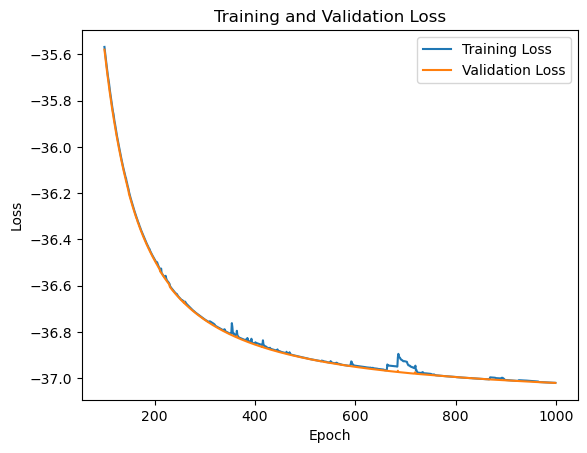

Test loss: -37.020694732666016


In [167]:
"""
Graph the losses
"""
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Check if early stopping occurred
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping happened at epoch: {early_stopping.stopped_epoch}.")
else:
    print("Training completed without early stopping.")

def plot_loss(history, validation_freq, skip_initial_epochs=5):
    total_epochs = len(history.history['loss'])
    val_epochs = len(history.history['val_loss'])
    
    # Calculate the starting epoch to plot
    start_epoch = min(skip_initial_epochs, total_epochs-3)

    # Calculate the corresponding x-ticks
    x_ticks = np.arange(start_epoch, total_epochs, validation_freq)
    
    # Ensure x_ticks do not exceed the total number of epochs
    x_ticks = x_ticks[x_ticks < total_epochs]
    x_ticks = x_ticks.tolist()

    # Calculate corresponding validation epochs for the ticks
    val_ticks = np.arange(start_epoch // validation_freq, val_epochs, validation_freq)


    plt.plot(x_ticks, [history.history['loss'][idx] for idx in x_ticks], label='Training Loss')
    plt.plot(val_ticks, [history.history['val_loss'][idx] for idx in val_ticks], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_loss(history, validation_freq, skip_initial_epochs=100)

test_loss = real_nvp_model.evaluate({"target":test_dfs[0].values, "conditioning":test_dfs[1].values}, 
                                         y=np.zeros((test_dfs[0].values.shape[0],0)), verbose=0)
print(f"Test loss: {test_loss}")

Median percentile and percentage of data within range: {'80.0%': 83.1989247311828, '50.0%': 61.424731182795696, '20.0%': 28.225806451612907}


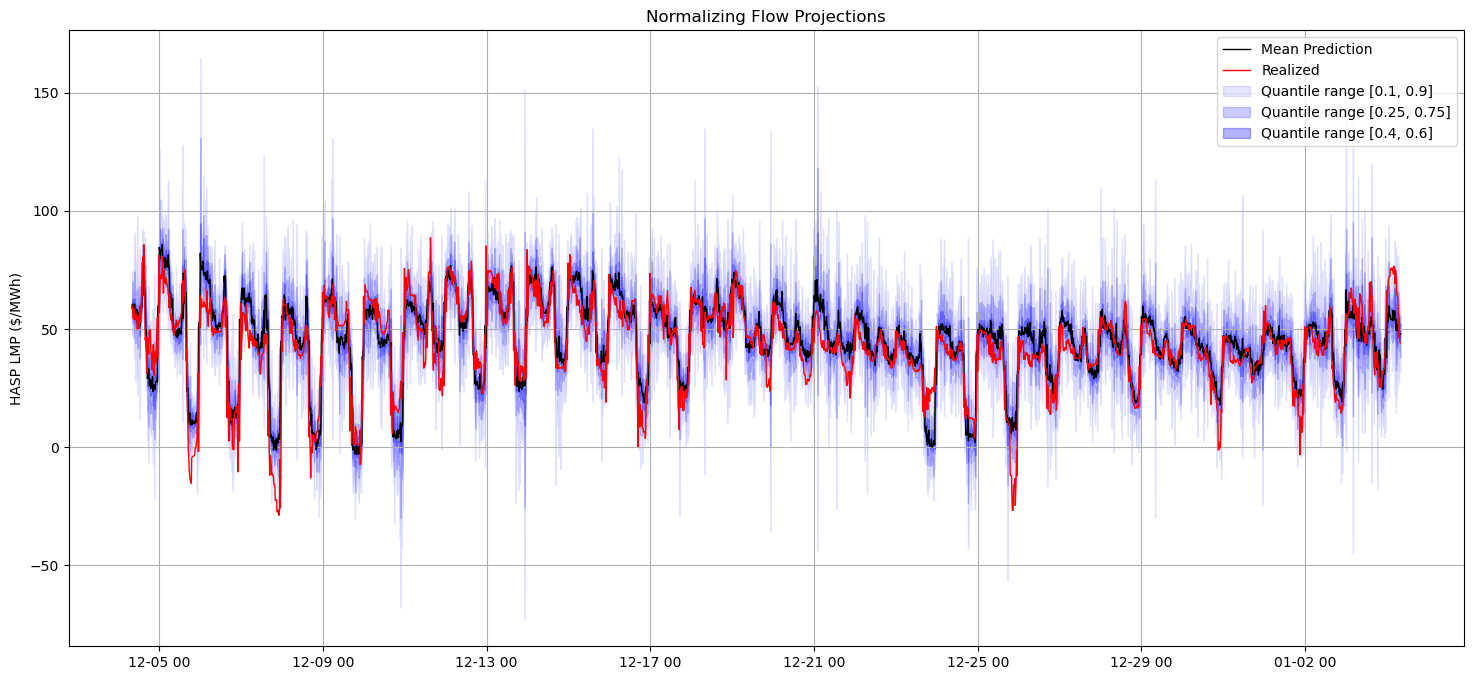

In [168]:
"""
Sample from trained distribution
"""
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

num_samples = 100
node="TH_SP15_GEN-APND"

# Get realized data of hourly DA LMP and HASP LMP
lmp_hasp_file_path = generate_file_path("lmp_hasp", start_datetime - timedelta(hours=1), 
    end_datetime, node=node
)
lmp_hasp_df = pd.read_csv(lmp_hasp_file_path, parse_dates=True, index_col="INTERVALSTARTTIME_GMT")
lmp_hasp_df, _ = impute_df(lmp_hasp_df, "lmp_hasp") # Impute missing data
test_lmp_hasp_series = lmp_hasp_df[val_cutoff:end_datetime].squeeze()


lmp_da_file_path = generate_file_path("lmp_da", start_datetime - timedelta(hours=1), 
    end_datetime + timedelta(hours=1), node=node
)
lmp_da_df = pd.read_csv(lmp_da_file_path, parse_dates=True, index_col="INTERVALSTARTTIME_GMT")
test_lmp_da_df = lmp_da_df[val_cutoff:end_datetime]

# Copy hourly data to 15-minute intervals
test_lmp_da_series = test_lmp_da_df.resample('15min').ffill().squeeze()[:-1]

valid_df_indices_to_remove = [index for index in indices_to_remove if index in test_lmp_da_df.index]
valid_series_indices_to_remove = [index + timedelta(minutes=15*i) for i in range(4) for index in valid_df_indices_to_remove]


test_lmp_da_series.drop(valid_series_indices_to_remove, inplace=True)
test_lmp_da_df = test_lmp_da_df.drop(valid_df_indices_to_remove)
test_lmp_hasp_series.drop(valid_series_indices_to_remove, inplace=True)

C_test_df = test_dfs[1]

# Generates samples for a single row of DF
def generate_samples(row, num_samples, distr, scaler=None):
    # Make num_samples copies of row
    repeated_rows = np.tile(row.values, (num_samples, 1))
    # print(repeated_rows)
    # Make dictionary for passing conditioning input
    bijector_kwargs = {bij.name: {"conditioning_input": repeated_rows} for bij in distr.bijector.bijectors}

    # Get scaled samples as EagerTensor
    scaled_samples = real_nvp_distr.sample(num_samples, bijector_kwargs=bijector_kwargs)

    # Unscale samples
    samples = scaler.inverse_transform(scaled_samples) if scaler else scaled_samples
    # Note: unclear why inverse_transform accepts EagerTensor; regardless, gives ndarray
    
    return pd.DataFrame(samples)

# Apply the function to each row of the DataFrame
# Series of len=len(C_test_df) of DFs of shape (num_samples, 4) with original datetime indices
samples_series = C_test_df.apply(generate_samples, 
                                 axis=1, num_samples=num_samples, 
                                 distr=real_nvp_distr, scaler=None)



# DF of shape (len(C_test_df),4) containing means for each 15-minute step of each hour
mean_values_df = samples_series.apply(lambda x: x.mean())

# List of percentile ranges of interest
q_values = [[0.1, 0.9], [0.25, 0.75], [0.4, 0.6]]

# Series of len=len(C_test_df) of DataFrames of shape (len(q_values),4) containing percentile cutoffs
lower_quantiles_series = samples_series.apply(lambda x: x.quantile(q=[q[0] for q in q_values])) + test_lmp_da_df.squeeze()[:-1]
upper_quantiles_series = samples_series.apply(lambda x: x.quantile(q=[q[1] for q in q_values])) + test_lmp_da_df.squeeze()[:-1]


# Rename columns of quantile Series
def rename_fn(df, q_values):
    return df.T.rename(columns={ind: f"{(q[1]*100-q[0]*100)}%" for ind, q in zip(df.index, q_values)})

lower_quantiles_series = lower_quantiles_series.apply(rename_fn, q_values=q_values)
upper_quantiles_series = upper_quantiles_series.apply(rename_fn, q_values=q_values)


# Make new indexing Series with 15-minute granularity
datetime_index = pd.date_range(start=C_test_df.index.min(), end=C_test_df.index.max()+timedelta(minutes=45), freq="15min")
datetime_index = datetime_index.difference(pd.DatetimeIndex(valid_series_indices_to_remove))

# Unravel the above Series of Series/DataFrame objects
unraveled_mean_values = mean_values_df.T.unstack() + test_lmp_da_series # Series of len=4*len(C_test_df)
unraveled_mean_values.index = datetime_index

# DFs of shape (4*len(C_test_df), len(q_values))
unraveled_lower_quantiles = pd.concat(lower_quantiles_series.tolist())
unraveled_lower_quantiles.index = datetime_index
unraveled_upper_quantiles = pd.concat(upper_quantiles_series.tolist())
unraveled_upper_quantiles.index = datetime_index



# Determine percentage of realized values within given percentile ranges
prediction_acc = {}
for col in unraveled_lower_quantiles.columns:
    prediction_acc[col] = ((unraveled_lower_quantiles[col] <= test_lmp_hasp_series) & 
                           (test_lmp_hasp_series <= unraveled_upper_quantiles[col])).mean()*100
print("Median percentile and percentage of data within range:", prediction_acc)

# print("Max mean value:", unraveled_mean_values.nlargest(10))


# Plot stuff
plt.figure(figsize=(18, 8))
plt.plot(datetime_index, unraveled_mean_values.values, color='black', label='Mean Prediction', linewidth=1.0)
plt.plot(datetime_index, test_lmp_hasp_series.values, color='red', label='Realized', linewidth=1.0)

# Set date format and tick frequency
date_fmt = mdates.DateFormatter('%m-%d %H')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4)) # Tick every 4 days

for i, q_range in enumerate(q_values):
    plt.fill_between(datetime_index, 
                     unraveled_lower_quantiles.iloc[:,i], 
                     unraveled_upper_quantiles.iloc[:,i], 
                     color='blue', alpha=0.1*(i+1), label=f'Quantile range {q_range}')

plt.legend()
plt.ylabel('HASP LMP ($/MWh)')
plt.title('Normalizing Flow Projections')
plt.grid(True)
plt.show()

In the remaining cells, we perform the same experiment in the setting of the German EPEX SPOT market, with 15-minute ID3 values in place of 15-minute HASP LMP values. This is done to compare our model with that of Cramer, et. al. 

We find our predictions to be notably less accurate, despite using the same hyperparameters outlined in the supplementary material to their paper: 4 affine coupling layers, fully connected conditioning models (presumably this means they use tfkl.Dense in their shift_and_log_scale_fn) with 2 hidden layers, 4 units per hidden layer, and 'relu' activation. There is no mention of batch normalization of regularization in the paper, but regardless, we are unable to reproduce their levels of accuracy. This is likely due to our architecture being suboptimal. 

In [154]:
"""
Create German market input feature DFs
"""

# Input features: forward and backward differences of day-ahead auction prices
def create_DE_da_delta_df(start_datetime, end_datetime, **kwargs):
    # Fetch data from folder_path or API
    da_df = build_df("DA", start_datetime-timedelta(hours=1), end_datetime+timedelta(hours=1), region="DE")

    # Impute (linearly interpolate) any missing data
    da_df, _ = impute_df(da_df, "lmp_da")

    # Get hourly day-ahead differences for given range
    forward_difference = -da_df.diff(periods = -1).loc[start_datetime:end_datetime-timedelta(minutes=1)]
    backward_difference = da_df.diff().loc[start_datetime:end_datetime-timedelta(minutes=1)]

    forward_difference.rename(columns={"MW":"DA_Forward_Difference"}, inplace=True)
    backward_difference.rename(columns={"MW":"DA_Backward_Difference"}, inplace=True)

    # Merge along index and rename indices
    da_delta_df = pd.concat([forward_difference, backward_difference], axis=1)

    return da_delta_df

    
# Input features: (id3_{x} - da) of previous hour for x in {0, 15, 30, 45}
def create_id3_da_diff_df(start_datetime, end_datetime, **kwargs):
    # Fetch data from folder_path or API
    id3_df = build_df("id3", start_datetime - timedelta(hours=1), end_datetime, region="DE")
    
    # Impute missing values
    id3_df, _ = impute_df(id3_df, "lmp_hasp")

    # Fetch data from folder_path or API
    full_da_df = build_df("DA", start_datetime-timedelta(hours=1), end_datetime+timedelta(hours=1), region="DE")

    # Impute missing values
    full_da_df, _ = impute_df(full_da_df, "lmp_da")

    # Set new start/end datetimes to calculuate LMP difference of previous hour
    new_start_datetime = start_datetime-timedelta(hours=1)
    new_end_datetime = end_datetime-timedelta(hours=1, minutes=1) # Subtract 1 minute to handle edge case
    
    # Make DataFrame to hold (lmp_hasp_{x} - lmp_da) input features
    id3_da_diff_df = pd.DataFrame(index = full_da_df[new_start_datetime:new_end_datetime].index)
    
    for i in range(4):
        # Form lmp_hasp_H{t-1}_M{x} - lmp_da_H{t-1} for x in {0, 15, 30, 45}
        id3_da_diff_df[f"HASP_DA_diff_{i*15}"] = (
            id3_df[new_start_datetime + timedelta(minutes=i*15):new_end_datetime:4].values - 
            full_da_df[new_start_datetime:new_end_datetime].values
        )

    # Shift indices ahead 1 hour to match with indices of other features
    id3_da_diff_df.index = id3_da_diff_df.index + pd.DateOffset(hours=1)

    return id3_da_diff_df

In [171]:
"""
Reset conditioning_df_creator_list for German market modeling
"""

# Collect conditioning DF creator functions into a list and set conditioning_dim and target_dim
conditioning_df_creator_list = [# create_renew_hasp_da_diff_df, 
                                # create_lmp_da_delta_df, 
                                # create_lmp_rtpd_da_diff_df, # Comment out unwanted features
                                # create_trig_time_df, 
                                # create_hasp_da_diff_df, 
                                # create_temperature_df, 
                                create_DE_da_delta_df, # Only these two are relevant for the DE market
                                create_id3_da_diff_df
                               ]

# Dict to hold values of input feature dimensionality
conditioning_dim_dict = {create_renew_hasp_da_diff_df: 2, 
                         create_lmp_da_delta_df: 2, 
                         create_lmp_rtpd_da_diff_df: 1, 
                         create_trig_time_df: 2, 
                         create_hasp_da_diff_df: 4,
                         create_temperature_df: 2, 
                         create_DE_da_delta_df: 2,
                         create_id3_da_diff_df: 4
                        }

conditioning_dim = sum(conditioning_dim_dict[fn] for fn in conditioning_df_creator_list)
target_dim = 4

In [351]:
"""
Set training hyperparameters and build model
"""
import tensorflow as tf
import tensorflow_probability as tfp
import time
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
tfkl = tfk.layers
import pytz

start_datetime = datetime(2018, 1, 1,1, 0, tzinfo=pytz.UTC)
train_cutoff = datetime(2019, 6, 1, 1, 0, tzinfo=pytz.UTC)
val_cutoff = datetime(2019, 7, 1, 1, 0, tzinfo=pytz.UTC)
end_datetime = datetime(2019, 7, 5, 1, 0, tzinfo=pytz.UTC)

# thresholds = {"HASP_DA_diff_00":(-150, 150),"HASP_DA_diff_45":(-150, 150)}
thresholds = None

# Time to build our model.
# Hyperparameters for shift and log_scale NNs
hidden_units = 4
hidden_activation = "relu"
num_hidden_layers= 2
num_coupling_layers = 5
log_scale_activation = "softsign"
log_scale_scaling_factor = 1

# Base distribution 'loc' and 'scale_diag' values
start_mean = 0
start_std = 8

dropout_rate = 0.0  # Dropout for each hidden layer
regularizer = None

# Add attention layer for determining best combination of activation functions for hidden layers
time_data_activation_attention = False
activation_functions=["softsign", "gelu"]
activation_units=2


# Specify number of masked units for d-th coupling layer, applied in increasing order for d in range(num_coupling_layers)
def mask_num_fn(num_coupling_layers, d):
    max_cutoff = num_coupling_layers // 4
    if d == 0:
        return 2 # Want no masked input in first layer in order to learn MVN 'loc' and 'scale_diag' values. 
    elif d <= 2*max_cutoff:
        return 2
    elif d <= 3*max_cutoff:
        return 2
    else:
        return 2

# Specify the permutations one wishes ot consider
manual_permute = False
permutations = [[1,2,3,0]]*num_coupling_layers
permutations = [tf.constant(permutation) for permutation in permutations]

# Specify the optimizer
optimizer = tfk.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.1) # Using M2 Air, need legacy

# Form the training, validation, and test datasets
train_dfs, val_dfs, test_dfs, scaler_X, indices_to_remove = create_datasets(start_datetime, end_datetime, train_cutoff, 
                                                                val_cutoff, region="DE")

# Create the configured model
real_nvp_model, real_nvp_distr = build_configured_model(optimizer)


In [352]:
"""
Train the model
"""
# Parameters for training:
total_epochs = 1000
validation_freq = 1

# Define EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor="val_loss", patience=20*validation_freq, restore_best_weights=True)

callbacks = [early_stopping]

# Train the model
history = real_nvp_model.fit({"target":train_dfs[0].values, "conditioning":train_dfs[1].values}, # Train data dict
                    y=np.zeros((train_dfs[0].values.shape[0],0)), # Dummy variable target
                    batch_size=128,
                    epochs=total_epochs, verbose=0, callbacks=callbacks, 
                    validation_data=((val_dfs[0].values, val_dfs[1].values), # Val data tuple
                    np.zeros((val_dfs[0].values.shape[0], 0))), # Dummy variable target
                    validation_freq=validation_freq
                    )




Early stopping happened at epoch: 805.


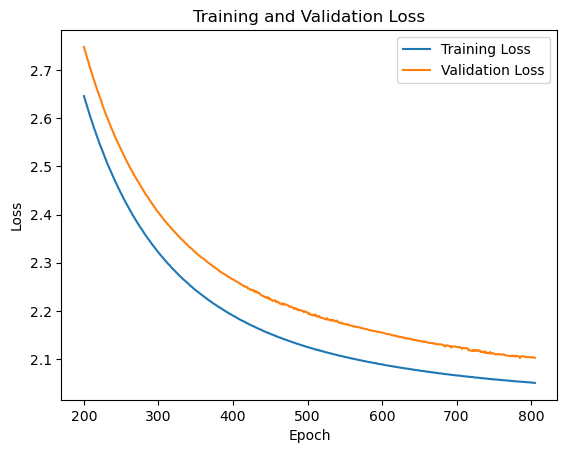

Test loss: 2.046212911605835


In [353]:
"""
Plot the losses
"""
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Check if early stopping occurred
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping happened at epoch: {early_stopping.stopped_epoch}.")
else:
    print("Training completed without early stopping.")

# for key,value in history.history.items():
#     print(key,value)
    

def plot_loss(history, validation_freq, skip_initial_epochs=5):
    total_epochs = len(history.history['loss'])
    val_epochs = len(history.history['val_loss'])
    
    # Calculate the starting epoch to plot
    start_epoch = min(skip_initial_epochs, total_epochs)

    # Calculate the corresponding x-ticks
    x_ticks = np.arange(start_epoch, total_epochs, validation_freq)
    
    # Ensure x_ticks do not exceed the total number of epochs
    x_ticks = x_ticks[x_ticks < total_epochs]
    x_ticks = x_ticks.tolist()

    # Calculate corresponding validation epochs for the ticks
    val_ticks = np.arange(start_epoch // validation_freq, val_epochs, validation_freq)


    plt.plot(x_ticks, [history.history['loss'][idx] for idx in x_ticks], label='Training Loss')
    plt.plot(val_ticks, [history.history['val_loss'][idx] for idx in val_ticks], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.yscale('log')  # Set y-axis to log scale
    # plt.ylim(0)
    plt.legend()
    plt.show()


plot_loss(history, validation_freq, skip_initial_epochs=200)

test_loss = real_nvp_model.evaluate({"target":test_dfs[0].values, "conditioning":test_dfs[1].values}, 
                                         y=np.zeros((test_dfs[0].values.shape[0],0)), verbose=0)
print(f"Test loss: {test_loss}")

Median percentile and percentage of data within range: {'80.0%': 76.30208333333334, '50.0%': 52.604166666666664, '20.0%': 22.916666666666664}


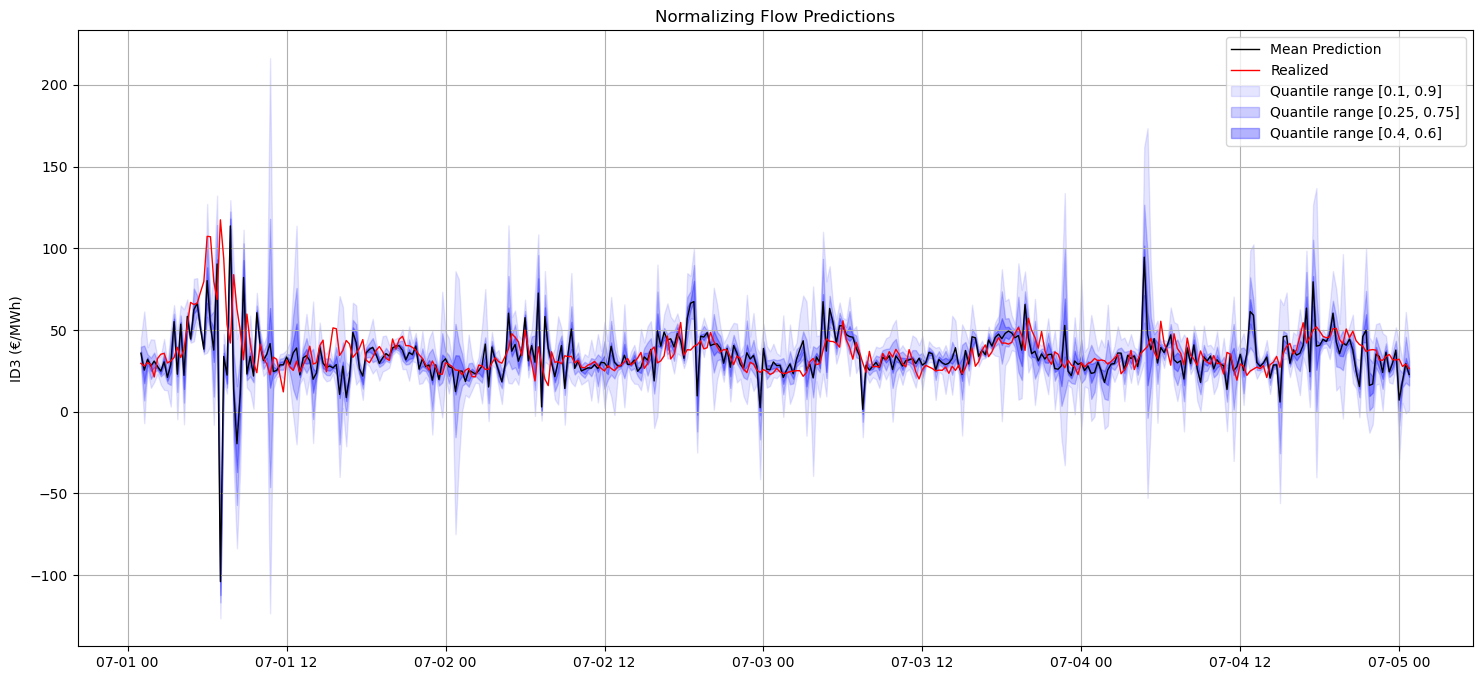

In [356]:
"""
Sample from transformed distribution on test data
"""

import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


num_samples = 100

# Get ID3 and DA data for German market
id3_df = build_df("id3", start_datetime, end_datetime, region="DE")
da_df = build_df("DA", start_datetime, end_datetime, region="DE")


# Select testing period data and form a series from the single column DF
test_id3_series = id3_df[val_cutoff:end_datetime-timedelta(minutes=1)].squeeze()

# Select testing period data
test_da_df = da_df[val_cutoff:end_datetime]

# Copy hourly data to 15-minute intervals and form Series
test_da_series = test_da_df.resample('15min').ffill().squeeze()[:-1]

# Remove any indices corresponding to data that was omitted due to optional 'thresholds' parameter
# First identify any indices to remove
valid_df_indices_to_remove = [index for index in indices_to_remove if index in test_da_df.index]
valid_series_indices_to_remove = [index + timedelta(minutes=15*i) for i in range(4) for index in valid_df_indices_to_remove]

# Drop any data from valid indices
test_da_series.drop(valid_series_indices_to_remove, inplace=True)
test_da_df = test_da_df.drop(valid_df_indices_to_remove)
test_id3_series.drop(valid_series_indices_to_remove, inplace=True)

C_test_df = test_dfs[1]


# Function to generate samples for a single row of DF
def generate_samples(row, num_samples, distr, scaler=None):
    # Make num_samples copies of row
    repeated_rows = np.tile(row.values, (num_samples, 1))
    
    # Make dictionary for passing conditioning input
    bijector_kwargs = {bij.name: {"conditioning_input": repeated_rows} for bij in distr.bijector.bijectors}

    # Get scaled samples as EagerTensor
    scaled_samples = real_nvp_distr.sample(num_samples, bijector_kwargs=bijector_kwargs)

    # Unscale samples
    samples = scaler.inverse_transform(scaled_samples) if scaler else scaled_samples
    # Note: unclear why inverse_transform accepts EagerTensor; regardless, gives ndarray
    
    return pd.DataFrame(samples)


# Apply the function to each row of the DataFrame
# Series of len=len(C_test_df) of DFs of shape (num_samples, 4) with original datetime indices
samples_series = C_test_df.apply(generate_samples, 
                                 axis=1, num_samples=num_samples, 
                                 distr=real_nvp_distr, scaler=None)

# DF of shape (len(C_test_df),4) containing means for each 15-minute step of each hour
mean_values_df = samples_series.apply(lambda x: x.mean())



# List of percentile ranges of interest
q_values = [[0.1, 0.9], [0.25, 0.75], [0.4, 0.6]]

# Series of len=len(C_test_df) of DataFrames of shape (len(q_values),4) containing percentile cutoffs
lower_quantiles_series = samples_series.apply(lambda x: x.quantile(q=[q[0] for q in q_values])) + test_da_df.squeeze()[:-1]
upper_quantiles_series = samples_series.apply(lambda x: x.quantile(q=[q[1] for q in q_values])) + test_da_df.squeeze()[:-1]



# Rename columns of quantile Series
def rename_fn(df, q_values):
    return df.T.rename(columns={ind: f"{(q[1]*100-q[0]*100)}%" for ind, q in zip(df.index, q_values)})

lower_quantiles_series = lower_quantiles_series.apply(rename_fn, q_values=q_values)
upper_quantiles_series = upper_quantiles_series.apply(rename_fn, q_values=q_values)



# Make new indexing Series with 15-minute granularity
datetime_index = pd.date_range(start=C_test_df.index.min(), end=C_test_df.index.max()+timedelta(minutes=45), freq="15min")
datetime_index = datetime_index.difference(pd.DatetimeIndex(valid_series_indices_to_remove))

# Unravel the above Series of Series/DataFrame objects
unraveled_mean_values = mean_values_df.T.unstack() + test_da_series # Series of len=4*len(C_test_df)
unraveled_mean_values.index = datetime_index

unraveled_lower_quantiles = pd.concat(lower_quantiles_series.tolist())  # DFs of shape (4*len(C_test_df), len(q_values))
unraveled_lower_quantiles.index = datetime_index
unraveled_upper_quantiles = pd.concat(upper_quantiles_series.tolist())
unraveled_upper_quantiles.index = datetime_index



# Determine percentage of realized values within given percentile ranges
prediction_acc = {}
for col in unraveled_lower_quantiles.columns:
    prediction_acc[col] = ((unraveled_lower_quantiles[col] <= test_id3_series) & 
                           (test_id3_series <= unraveled_upper_quantiles[col])).mean()*100
print("Median percentile and percentage of data within range:", prediction_acc)

# print("Max mean value:", unraveled_mean_values.nlargest(10))
plt.figure(figsize=(18, 8))


# Plot stuff
plt.plot(datetime_index, unraveled_mean_values.values, color='black', label='Mean Prediction', linewidth=1.0)
plt.plot(datetime_index, test_id3_series.values, color='red', label='Realized', linewidth=1.0)

# Set date format and tick frequency
date_fmt = mdates.DateFormatter('%m-%d %H')
plt.gca().xaxis.set_major_formatter(date_fmt)
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4)) # Tick every 4 days

for i, q_range in enumerate(q_values):
    plt.fill_between(datetime_index, 
                     unraveled_lower_quantiles.iloc[:,i], 
                     unraveled_upper_quantiles.iloc[:,i], 
                     color='blue', alpha=0.1*(i+1), label=f'Quantile range {q_range}')

plt.legend()
plt.ylabel('ID3 (€/MWh)')
plt.title('Normalizing Flow Predictions')
plt.grid(True)
plt.show()

In [ ]:
import pytz

start_datetime = datetime(2022, 1, 4, 8, 0, tzinfo=pytz.UTC)
train_cutoff = datetime(2023, 10, 4, 8, 0, tzinfo=pytz.UTC)
val_cutoff = datetime(2023, 12, 4, 8, 0, tzinfo=pytz.UTC)
end_datetime = datetime(2024, 1, 4, 8, 0, tzinfo=pytz.UTC)


# test = create_hasp_da_diff_df(start_datetime, end_datetime)
# print(test)

# test2 = create_renew_hasp_da_diff_df(start_datetime, end_datetime)
# print(test2)

# test3 = create_lmp_da_delta_df(start_datetime, end_datetime)
# print(test3)

# test4 = create_lmp_rtpd_da_diff_df(start_datetime, end_datetime)
# print(test4)

# test5 = create_target_df(start_datetime, end_datetime)
# print(test5)

# test6 = create_trig_time_df(start_datetime, end_datetime)
# print(test6)

# test7 = create_datasets(start_datetime, end_datetime, train_cutoff, val_cutoff)
# print(test7)

# test8 = create_temperature_df(start_datetime, end_datetime)
# print(test8["tmpf_avg_tmpf_diff"].nsmallest(50))

# test9 = create_DE_da_delta_df(start_datetime, end_datetime)
# print(test9)

# test10 = create_ide3_da_delta_df(start_datetime, end_datetime)
# print(test10)

# print(missing)